# Importing all the necesaary libraries

In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
nltk.download("stopwords")
nltk.download('punkt')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import re
from tqdm import tqdm, tqdm_notebook
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report
import joblib
from joblib import Memory
import os
import warnings
import numpy as np

C:\Users\Lohit Marodia\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package stopwords to C:\Users\Lohit
[nltk_data]     Marodia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Lohit
[nltk_data]     Marodia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Loading data and exploratory analysis

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.columns

Index(['Reviewer Name', 'Review Title', 'Place of Review', 'Up Votes',
       'Down Votes', 'Month', 'Review text', 'Ratings'],
      dtype='object')

In [4]:
df.head()

Reviewer Name               Review Title  \
0            Kamal Suresh               Nice product   
1       Flipkart Customer     Don't waste your money   
2  A. S. Raja Srinivasan   Did not meet expectations   
3     Suresh Narayanasamy                       Fair   
4               ASHIK P A                Over priced   

               Place of Review  Up Votes  Down Votes     Month  \
0   Certified Buyer, Chirakkal     889.0        64.0  Feb 2021   
1   Certified Buyer, Hyderabad     109.0         6.0  Feb 2021   
2  Certified Buyer, Dharmapuri      42.0         3.0  Apr 2021   
3     Certified Buyer, Chennai      25.0         1.0       NaN   
4                          NaN     147.0        24.0  Apr 2016   

                                         Review text  Ratings  
0  Nice product, good quality, but price is now r...        4  
1  They didn't supplied Yonex Mavis 350. Outside ...        1  
2  Worst product. Damaged shuttlecocks packed in ...        1  
3  Quite O. K. , but nowadays  the quality of the...        3  
4  Over pricedJust â?¹620 ..from retailer.I didn'...        1

In [5]:
df.shape

(8518, 8)

In [6]:
df_r3 = df[df['Ratings'] == 3]
print(df_r3.head(10))

             Reviewer Name    Review Title  \
3      Suresh Narayanasamy            Fair   
38       Flipkart Customer  Decent product   
75                Sanjay R       Just okay   
127      Flipkart Customer       Just okay   
133  VANTALA  CHANDRABABU             Good   
159      Flipkart Customer        Horrible   
177        Madhu Chandar S    Does the job   
180            Kiran Dokka            Nice   
184         satya narayana            Good   
193      Flipkart Customer            Good   

                             Place of Review  Up Votes  Down Votes     Month  \
3                   Certified Buyer, Chennai      25.0         1.0       NaN   
38           Certified Buyer, Charingia Gaon       3.0         0.0  Jan 2021   
75                 Certified Buyer, Hosdurga       1.0         0.0  Aug 2020   
127               Certified Buyer, Bengaluru       0.0         0.0       NaN   
133           Certified Buyer, Visakhapatnam       1.0         0.0       NaN   
159          

# Condering rating 3 as negative sentiment

In [7]:
df.isnull().sum()

Reviewer Name       10
Review Title        10
Place of Review     50
Up Votes            10
Down Votes          10
Month              465
Review text          8
Ratings              0
dtype: int64

# Removing records with Null Review text and remove READ MORE 

In [8]:
df = df.dropna(subset=['Review text'])

In [9]:
df.shape

(8510, 8)

In [10]:
df['Review text'] = df['Review text'].str.replace('READ MORE', '')

# Sentiment Mapping

In [11]:
# Create a mapping dictionary for sentiment labels
# 0 for Negative sentiment and 1 for Positive sentiment
sentiment_mapping = {
    1: 0,
    2: 0,
    3: 0,
    4: 1,
    5: 1
}

# Convert numerical values in score to sentiment labels
df['Sentiment'] =df['Ratings'].map(sentiment_mapping)

In [12]:
df.head()

Reviewer Name               Review Title  \
0            Kamal Suresh               Nice product   
1       Flipkart Customer     Don't waste your money   
2  A. S. Raja Srinivasan   Did not meet expectations   
3     Suresh Narayanasamy                       Fair   
4               ASHIK P A                Over priced   

               Place of Review  Up Votes  Down Votes     Month  \
0   Certified Buyer, Chirakkal     889.0        64.0  Feb 2021   
1   Certified Buyer, Hyderabad     109.0         6.0  Feb 2021   
2  Certified Buyer, Dharmapuri      42.0         3.0  Apr 2021   
3     Certified Buyer, Chennai      25.0         1.0       NaN   
4                          NaN     147.0        24.0  Apr 2016   

                                         Review text  Ratings  Sentiment  
0  Nice product, good quality, but price is now r...        4          1  
1  They didn't supplied Yonex Mavis 350. Outside ...        1          0  
2  Worst product. Damaged shuttlecocks packed in ...        1          0  
3  Quite O. K. , but nowadays  the quality of the...        3          0  
4  Over pricedJust â?¹620 ..from retailer.I didn'...        1          0

In [13]:
df = df[["Review text", "Sentiment"]] 
df.shape

(8510, 2)

In [14]:
df.rename(columns={'Review text': 'Text'}, inplace=True)

In [15]:
df.head()

Text  Sentiment
0  Nice product, good quality, but price is now r...          1
1  They didn't supplied Yonex Mavis 350. Outside ...          0
2  Worst product. Damaged shuttlecocks packed in ...          0
3  Quite O. K. , but nowadays  the quality of the...          0
4  Over pricedJust â?¹620 ..from retailer.I didn'...          0

In [16]:
df['Sentiment'].value_counts(normalize=True)

Sentiment
1    0.801763
0    0.198237
Name: proportion, dtype: float64

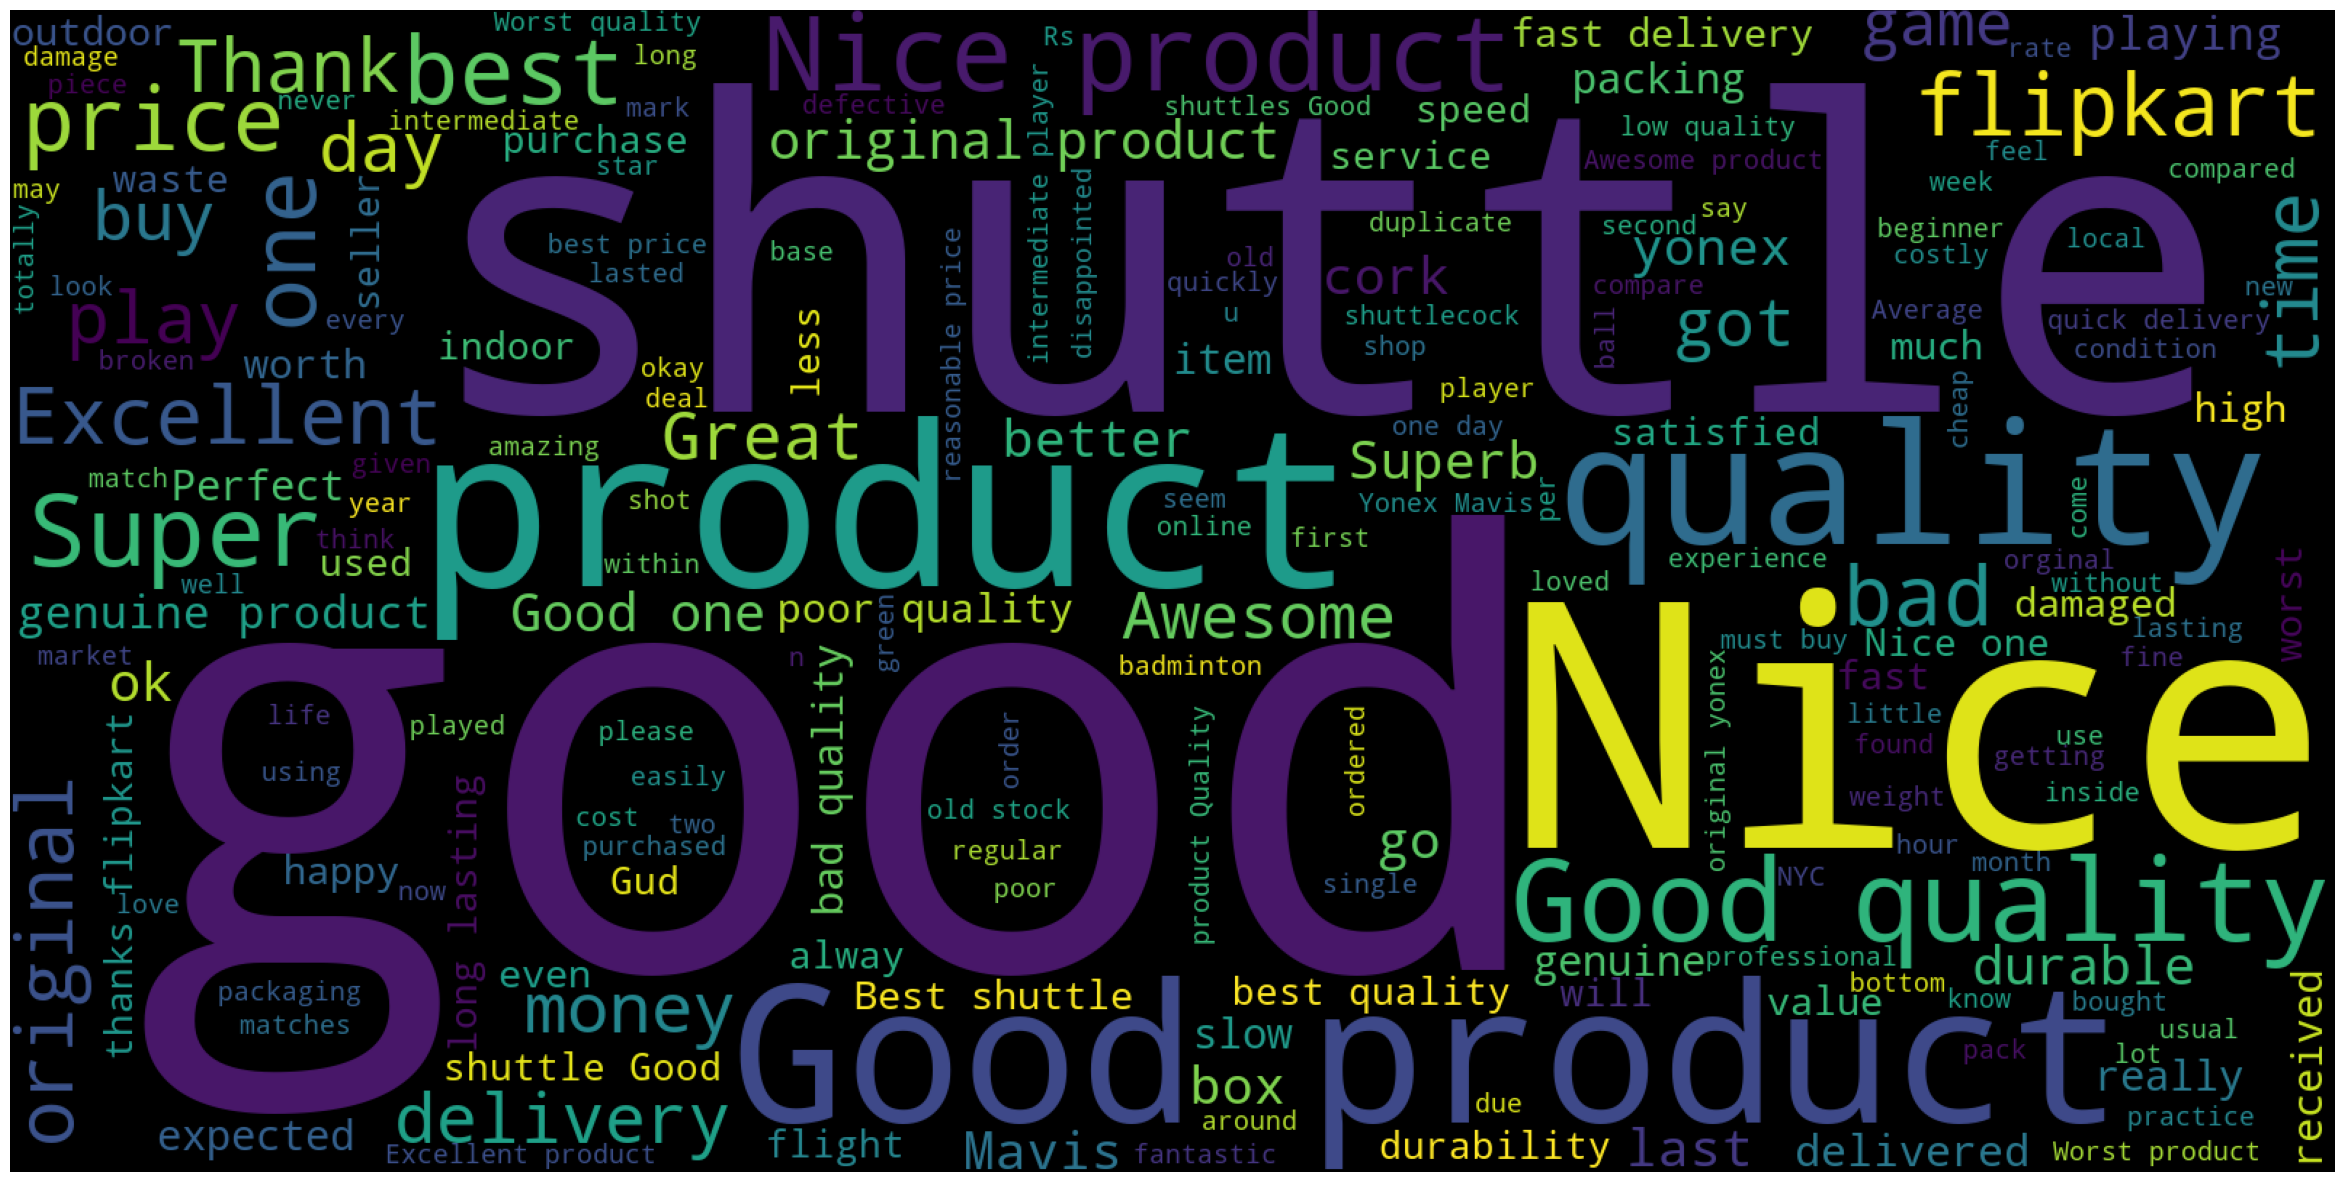

In [17]:
wc = WordCloud(background_color='black',
               width=1600,
               height=800).generate(' '.join(df['Text']))

plt.figure(1,figsize=(30,20))
plt.imshow(wc)
plt.axis('off')
plt.show()

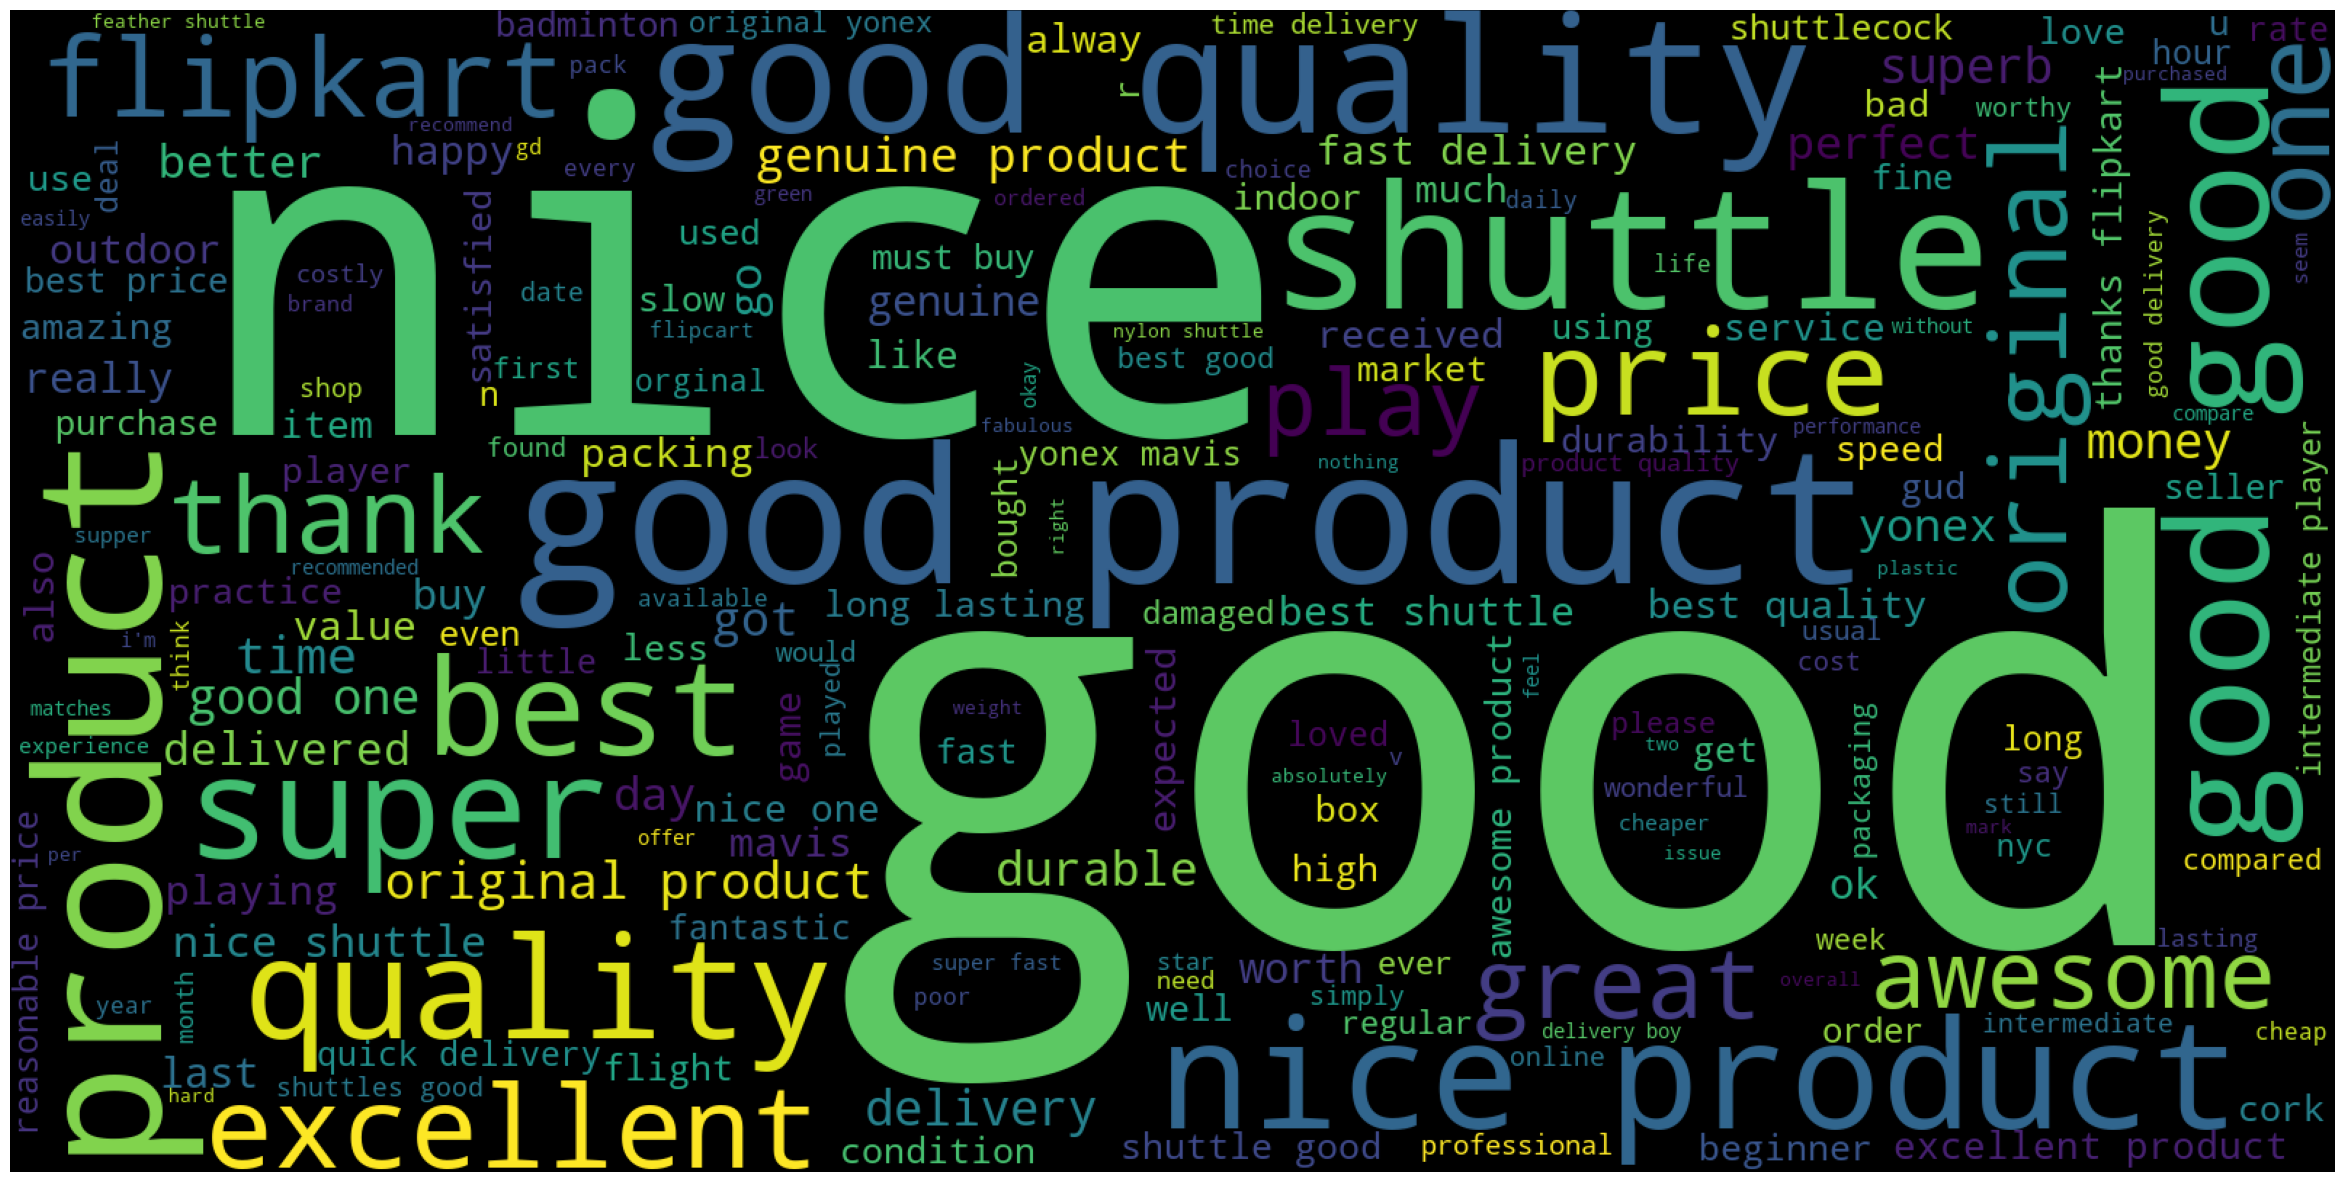

In [18]:
# Create a DataFrame for positive sentiments
df_positive = df.loc[df["Sentiment"] == 1, :]

# Join the positive sentences
words = " ".join(df_positive["Text"]).lower()

# Create a WordCloud object
positive_wc = WordCloud(stopwords=stopwords.words("english"),
                               background_color='black',
                               width=1600,
                               height=800
                              ).generate(words)

# Plot the WordCloud
plt.figure(figsize=(30, 20))
plt.imshow(positive_wc)
plt.axis('off')
plt.show()

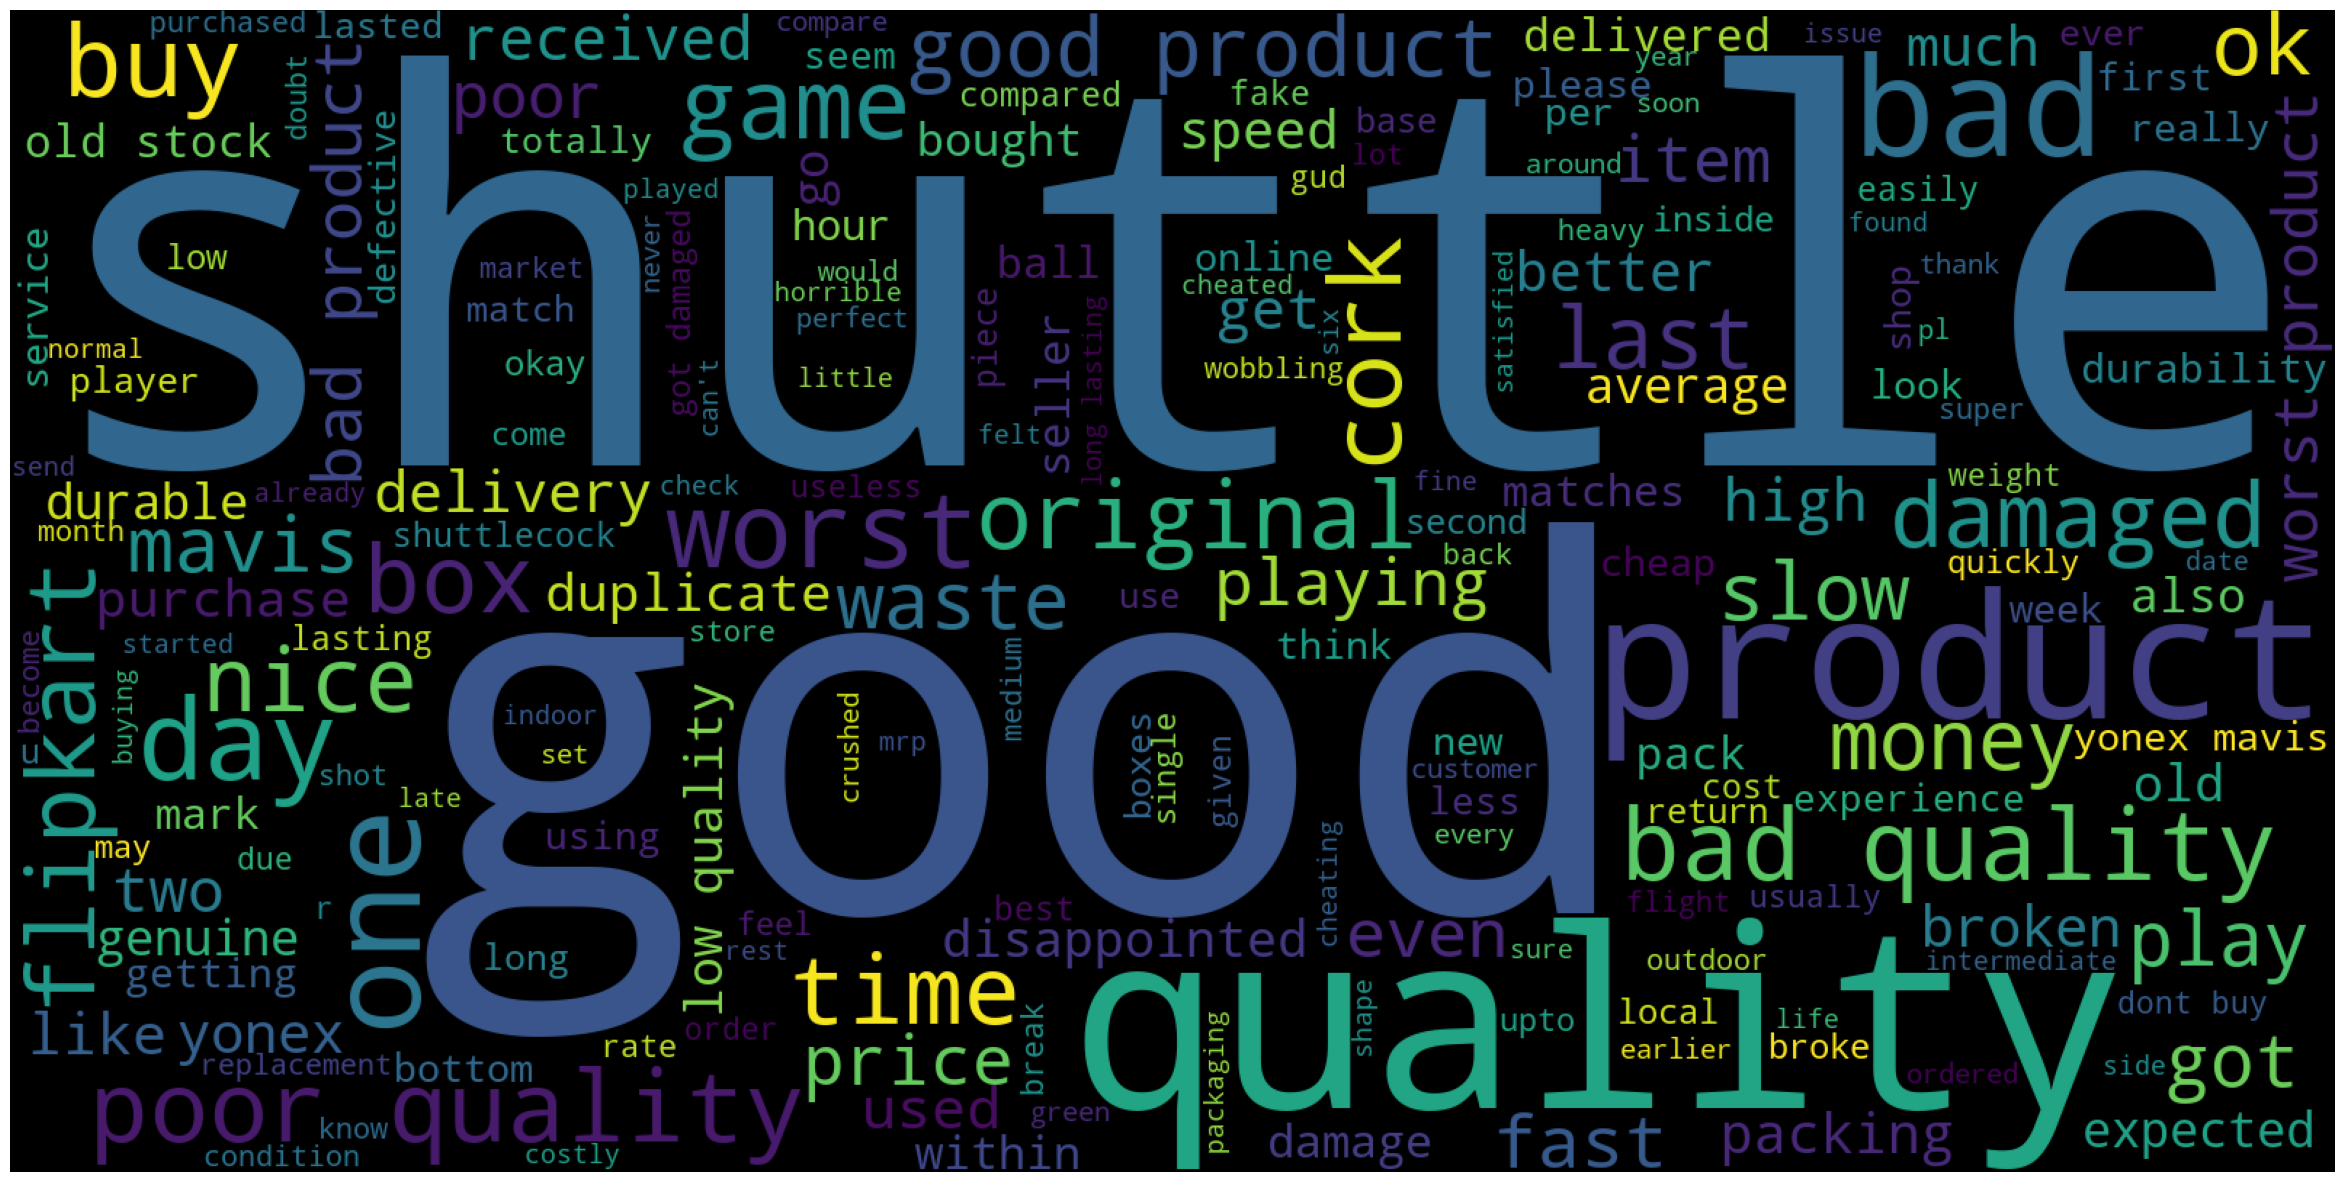

In [19]:
# Create a DataFrame for negative sentiments
df_negative = df.loc[df["Sentiment"] == 0, :]

# Join the positive sentences
words = " ".join(df_negative["Text"]).lower()

# Create a WordCloud object
negative_wc = WordCloud(stopwords=stopwords.words("english"),
                               background_color='black',
                               width=1600,
                               height=800
                              ).generate(words)

# Plot the WordCloud
plt.figure(figsize=(30, 20))
plt.imshow(negative_wc)
plt.axis('off')
plt.show()

# Step-1: Identify Input & Output
### Input = Review text (text) 
### Output = Positive / Negative

In [20]:
X = df.Text # the column text contains textual data to extract features from
y = df.Sentiment # this is the column we are learning to predict. 
print(X.shape, y.shape)

(8510,) (8510,)


# Step-2: Data Spilt

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6382,) (6382,)
(2128,) (2128,)


In [22]:
X_train.head()

1095                                          Very nice 👍
7326                             Very good on dry weather
1377                                           Well brand
2127    Firstly  Yonex is best company  for badminton ...
5096                                                 Good
Name: Text, dtype: object

In [23]:
X_train.shape

(6382,)

# Step-3: Data Preprocessing (Input)(test)

In [24]:
# Initialize Porter Stemmer
stemmer=PorterStemmer()

def clean(doc): 
    # This text contains a lot of <br/> tags.
    doc = doc.replace("<br/>", " ")
    
    # Removing special characters and digits
    doc = re.sub("[^a-zA-Z]", " ", doc)

    # Converting to lower case
    doc = doc.lower()
    
    # Tokenization
    tokens = nltk.word_tokenize(doc)

    # Stemming
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    # Stop word removal
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in stemmed_tokens if word.lower() not in stop_words]
    
    # Join and return
    return " ".join(filtered_tokens)

In [25]:
# Register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`
tqdm.pandas()

In [26]:
# Now you can use `progress_apply` instead of `apply`
# and `progress_map` instead of `map`

temp_df = X_train.progress_apply(lambda x: clean(x))
temp_df.head()

100%|██████████| 6382/6382 [00:02<00:00, 2496.65it/s]


1095                                            veri nice
7326                                veri good dri weather
1377                                           well brand
2127    firstli yonex best compani badminton thi shutt...
5096                                                 good
Name: Text, dtype: object

In [27]:
X_train = pd.concat([X_train, temp_df], axis=1)
X_train.head()

Text  \
1095                                        Very nice 👍   
7326                           Very good on dry weather   
1377                                         Well brand   
2127  Firstly  Yonex is best company  for badminton ...   
5096                                               Good   

                                                   Text  
1095                                          veri nice  
7326                              veri good dri weather  
1377                                         well brand  
2127  firstli yonex best compani badminton thi shutt...  
5096                                               good

In [28]:
X_train.columns = ['Text','clean_text']

In [29]:
X_train.head()

Text  \
1095                                        Very nice 👍   
7326                           Very good on dry weather   
1377                                         Well brand   
2127  Firstly  Yonex is best company  for badminton ...   
5096                                               Good   

                                             clean_text  
1095                                          veri nice  
7326                              veri good dri weather  
1377                                         well brand  
2127  firstli yonex best compani badminton thi shutt...  
5096                                               good

In [30]:
y_train

1095    1
7326    1
1377    1
2127    1
5096    1
       ..
2895    1
7813    1
905     1
5192    0
235     0
Name: Sentiment, Length: 6382, dtype: int64

# Converting Text to Numerical vectors - BOW Representation

In [31]:
X_train.head()

Text  \
1095                                        Very nice 👍   
7326                           Very good on dry weather   
1377                                         Well brand   
2127  Firstly  Yonex is best company  for badminton ...   
5096                                               Good   

                                             clean_text  
1095                                          veri nice  
7326                              veri good dri weather  
1377                                         well brand  
2127  firstli yonex best compani badminton thi shutt...  
5096                                               good

In [32]:
vocab = CountVectorizer()
X_train_bow = vocab.fit_transform(X_train['clean_text'])

In [33]:
X_train_bow

<6382x1869 sparse matrix of type '<class 'numpy.int64'>'
	with 22468 stored elements in Compressed Sparse Row format>

In [34]:
print("Total unique words:", len(vocab.vocabulary_))
print("Type of train features:", type(X_train_bow))
print("Shape of input data:", X_train_bow.shape)

Total unique words: 1869
Type of train features: <class 'scipy.sparse._csr.csr_matrix'>
Shape of input data: (6382, 1869)


In [35]:
print(X_train_bow.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [36]:
from sys import getsizeof

print(type(X_train_bow))
print(getsizeof(X_train_bow), "Bytes")

<class 'scipy.sparse._csr.csr_matrix'>
56 Bytes


In [37]:
print(type(X_train_bow.toarray()))
print(getsizeof(X_train_bow.toarray()), "Bytes")

<class 'numpy.ndarray'>
95423792 Bytes


# Step-4: Data Preprocessing (Input)(train)

In [38]:
X_test.head()

3733                               Awesome....
3491                                      good
2532                                      Nice
4429    very nice product 👌👌 at a better price
2698                           Genuine product
Name: Text, dtype: object

In [39]:
temp_df = X_test.progress_apply(lambda x: clean(x))
temp_df.head()

100%|██████████| 2128/2128 [00:00<00:00, 2660.35it/s]


3733                            awesom
3491                              good
2532                              nice
4429    veri nice product better price
2698                    genuin product
Name: Text, dtype: object

In [40]:
X_test = pd.concat([X_test, temp_df], axis=1)
X_test.head()

Text                            Text
3733                             Awesome....                          awesom
3491                                    good                            good
2532                                    Nice                            nice
4429  very nice product 👌👌 at a better price  veri nice product better price
2698                         Genuine product                  genuin product

In [41]:
X_test.columns = ['Text','clean_text']

In [42]:
X_test.head()

Text                      clean_text
3733                             Awesome....                          awesom
3491                                    good                            good
2532                                    Nice                            nice
4429  very nice product 👌👌 at a better price  veri nice product better price
2698                         Genuine product                  genuin product

In [43]:
X_test_bow = vocab.transform(X_test['clean_text'])

# Step-5: Model Building (i.e Train the classifier)
# Step-6: Evaluation on train data (Mock test)
# Step-7: Evaluation on test data (Final test)

# Logistic Regression

In [44]:
lr= LogisticRegression()
lr.fit(X_train_bow, y_train)

LogisticRegression()

In [45]:
y_train_pred_lr = lr.predict(X_train_bow)

In [46]:
print(accuracy_score(y_train, y_train_pred_lr))
print(classification_report(y_train, y_train_pred_lr))

0.9106863052334692
              precision    recall  f1-score   support

           0       0.91      0.61      0.73      1274
           1       0.91      0.99      0.95      5108

    accuracy                           0.91      6382
   macro avg       0.91      0.80      0.84      6382
weighted avg       0.91      0.91      0.90      6382



Text(0.5, 23.52222222222222, 'Predicted')

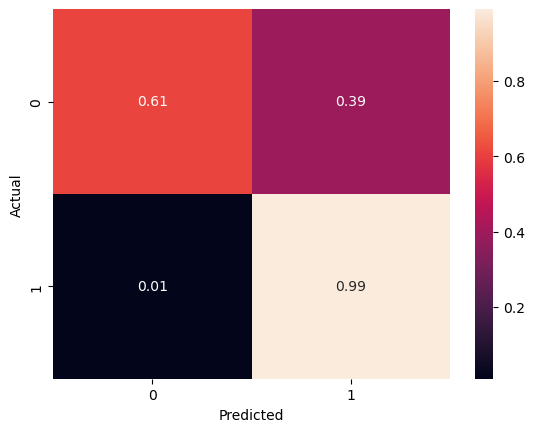

In [47]:
cm = metrics.confusion_matrix(y_train, y_train_pred_lr)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [48]:
y_test_pred_lr = lr.predict(X_test_bow)

In [49]:
print(accuracy_score(y_test, y_test_pred_lr))
print(classification_report(y_test, y_test_pred_lr))

0.8834586466165414
              precision    recall  f1-score   support

           0       0.82      0.51      0.63       413
           1       0.89      0.97      0.93      1715

    accuracy                           0.88      2128
   macro avg       0.86      0.74      0.78      2128
weighted avg       0.88      0.88      0.87      2128



Text(0.5, 23.52222222222222, 'Predicted')

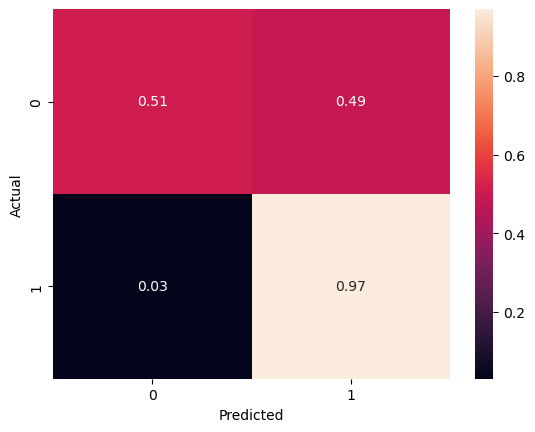

In [50]:
cm = metrics.confusion_matrix(y_test, y_test_pred_lr)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Decision Tree

In [51]:
dt = DecisionTreeClassifier()
dt.fit(X_train_bow, y_train)

DecisionTreeClassifier()

In [52]:
y_train_pred_dt = dt.predict(X_train_bow)

In [53]:
print(accuracy_score(y_train, y_train_pred_dt))
print(classification_report(y_train, y_train_pred_dt))

0.9540896270761516
              precision    recall  f1-score   support

           0       0.95      0.81      0.88      1274
           1       0.96      0.99      0.97      5108

    accuracy                           0.95      6382
   macro avg       0.95      0.90      0.92      6382
weighted avg       0.95      0.95      0.95      6382



Text(0.5, 23.52222222222222, 'Predicted')

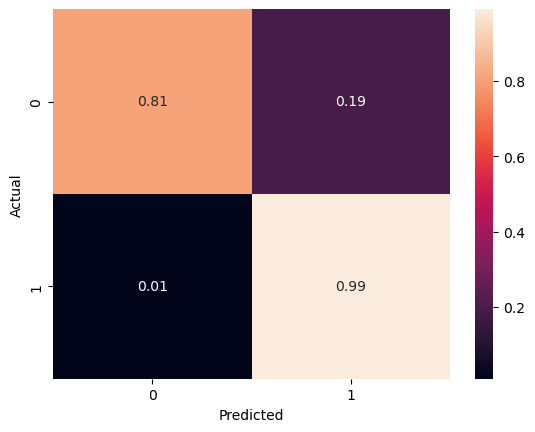

In [54]:
cm = metrics.confusion_matrix(y_train, y_train_pred_dt)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=dt.classes_, yticklabels=dt.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [55]:
y_test_pred_dt = dt.predict(X_test_bow)

In [56]:
print(accuracy_score(y_test, y_test_pred_dt))

print(classification_report(y_test, y_test_pred_dt))

0.8486842105263158
              precision    recall  f1-score   support

           0       0.63      0.52      0.57       413
           1       0.89      0.93      0.91      1715

    accuracy                           0.85      2128
   macro avg       0.76      0.73      0.74      2128
weighted avg       0.84      0.85      0.84      2128



Text(0.5, 23.52222222222222, 'Predicted')

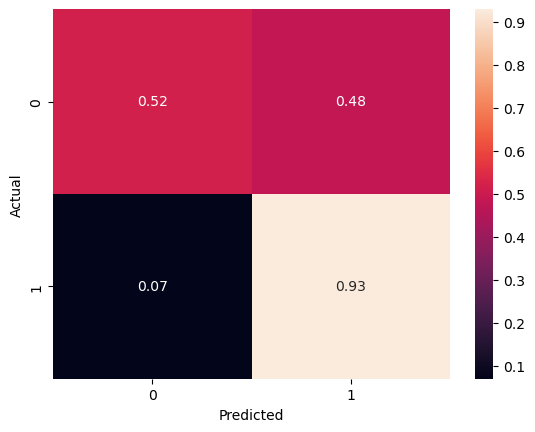

In [57]:
cm = metrics.confusion_matrix(y_test, y_test_pred_dt)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=dt.classes_, yticklabels=dt.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Random Forest

In [58]:
rf = RandomForestClassifier()
rf.fit(X_train_bow, y_train)

RandomForestClassifier()

In [59]:
y_train_pred_rf = rf.predict(X_train_bow)

In [60]:
print(accuracy_score(y_train, y_train_pred_rf))
print(classification_report(y_train, y_train_pred_rf))

0.9540896270761516
              precision    recall  f1-score   support

           0       0.96      0.80      0.87      1274
           1       0.95      0.99      0.97      5108

    accuracy                           0.95      6382
   macro avg       0.96      0.90      0.92      6382
weighted avg       0.95      0.95      0.95      6382



Text(0.5, 23.52222222222222, 'Predicted')

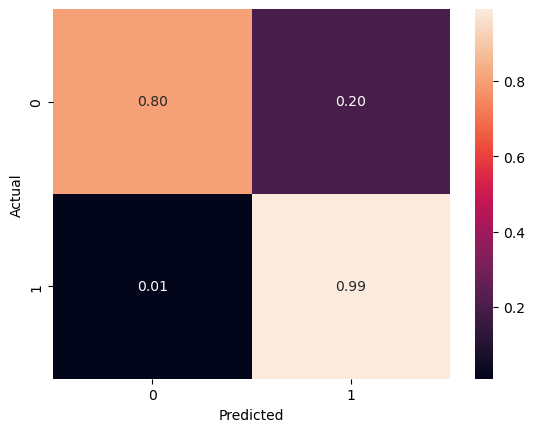

In [61]:
cm = metrics.confusion_matrix(y_train, y_train_pred_rf)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [62]:
y_test_pred_rf = rf.predict(X_test_bow)

In [63]:
print(accuracy_score(y_test, y_test_pred_rf))
print(classification_report(y_test, y_test_pred_rf))

0.8764097744360902
              precision    recall  f1-score   support

           0       0.75      0.54      0.63       413
           1       0.90      0.96      0.93      1715

    accuracy                           0.88      2128
   macro avg       0.82      0.75      0.78      2128
weighted avg       0.87      0.88      0.87      2128



Text(0.5, 23.52222222222222, 'Predicted')

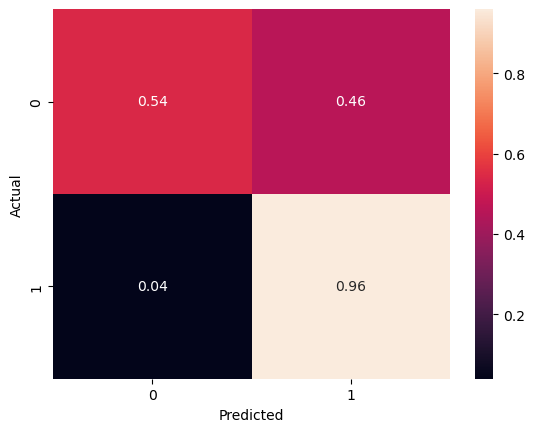

In [64]:
cm = metrics.confusion_matrix(y_test, y_test_pred_rf)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Naive Bayes

In [65]:
nb = MultinomialNB()
nb.fit(X_train_bow, y_train)

MultinomialNB()

In [66]:
y_train_pred_nb = nb.predict(X_train_bow)

In [67]:
print(accuracy_score(y_train, y_train_pred_nb))
print(classification_report(y_train, y_train_pred_nb))

0.9019116264493889
              precision    recall  f1-score   support

           0       0.86      0.61      0.71      1274
           1       0.91      0.98      0.94      5108

    accuracy                           0.90      6382
   macro avg       0.88      0.79      0.83      6382
weighted avg       0.90      0.90      0.90      6382



Text(0.5, 23.52222222222222, 'Predicted')

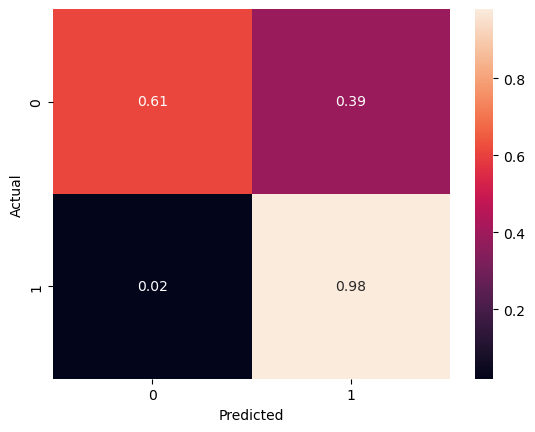

In [68]:
cm = metrics.confusion_matrix(y_train, y_train_pred_nb)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [69]:
y_test_pred_nb = nb.predict(X_test_bow)

In [70]:
print(accuracy_score(y_test, y_test_pred_nb))
print(classification_report(y_test, y_test_pred_nb))

0.8843984962406015
              precision    recall  f1-score   support

           0       0.81      0.53      0.64       413
           1       0.89      0.97      0.93      1715

    accuracy                           0.88      2128
   macro avg       0.85      0.75      0.78      2128
weighted avg       0.88      0.88      0.87      2128



Text(0.5, 23.52222222222222, 'Predicted')

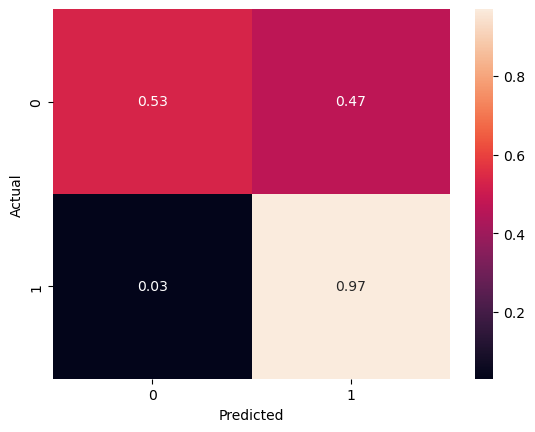

In [71]:
cm = metrics.confusion_matrix(y_test, y_test_pred_nb)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

## Analysing all models

In [72]:
print("Logistic Regression")
print("Accuracy on Train data:", metrics.accuracy_score(y_train, y_train_pred_lr))
print("Accuracy on Test data:", metrics.accuracy_score(y_test, y_test_pred_lr))
print("Train Score (F1 Score):", metrics.f1_score(y_train, y_train_pred_lr))
print("Test Score (F1 Score):", metrics.f1_score(y_test, y_test_pred_lr))
print("Decision Tree")
print("Accuracy on Train data:", metrics.accuracy_score(y_train, y_train_pred_dt))
print("Accuracy on Test data:", metrics.accuracy_score(y_test, y_test_pred_dt))
print("Train Score (F1 Score):", metrics.f1_score(y_train, y_train_pred_dt))
print("Test Score (F1 Score):", metrics.f1_score(y_test, y_test_pred_dt))
print("Random Forest")
print("Accuracy on Train data:", metrics.accuracy_score(y_train, y_train_pred_rf))
print("Accuracy on Test data:", metrics.accuracy_score(y_test, y_test_pred_rf))
print("Train Score (F1 Score):", metrics.f1_score(y_train, y_train_pred_rf))
print("Test Score (F1 Score):", metrics.f1_score(y_test, y_test_pred_rf))
print("Naive Bayes")
print("Accuracy on Train data:", metrics.accuracy_score(y_train, y_train_pred_nb))
print("Accuracy on Test data:", metrics.accuracy_score(y_test, y_test_pred_nb))
print("Train Score (F1 Score):", metrics.f1_score(y_train, y_train_pred_nb))
print("Test Score (F1 Score):", metrics.f1_score(y_test, y_test_pred_nb))

Logistic Regression
Accuracy on Train data: 0.9106863052334692
Accuracy on Test data: 0.8834586466165414
Train Score (F1 Score): 0.9463983449313522
Test Score (F1 Score): 0.9308807134894092
Decision Tree
Accuracy on Train data: 0.9540896270761516
Accuracy on Test data: 0.8486842105263158
Train Score (F1 Score): 0.9718242138667181
Test Score (F1 Score): 0.9080525414049114
Random Forest
Accuracy on Train data: 0.9540896270761516
Accuracy on Test data: 0.8764097744360902
Train Score (F1 Score): 0.9719214183037853
Test Score (F1 Score): 0.9258110014104373
Naive Bayes
Accuracy on Train data: 0.9019116264493889
Accuracy on Test data: 0.8843984962406015
Train Score (F1 Score): 0.9408764639214205
Test Score (F1 Score): 0.9312080536912751


# Choosing Logistic Regression

In [73]:
filename = "lr_bow.pkl"
joblib.dump(lr, filename)

['lr_bow.pkl']

In [74]:
model = joblib.load('lr_bow.pkl')

In [75]:
y_test_pred = model.predict(X_test_bow)

In [76]:
print(accuracy_score(y_test,y_test_pred))

0.8834586466165414


In [77]:
filename = "vectorizer.pkl"
joblib.dump(vocab, filename)

['vectorizer.pkl']